In [22]:
%matplotlib inline

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import astropy.stats as aps

from kinematics_and_rotation.dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load data and make cuts.

31357
(29462, 134) no large vb uncertainties
(29243, 134) no faint stars
(23070, 134) no hot or cold stars
(16246, 134) no high latitude stars
niter =  6 294 stars removed kurtosis =  0.10568462462780426


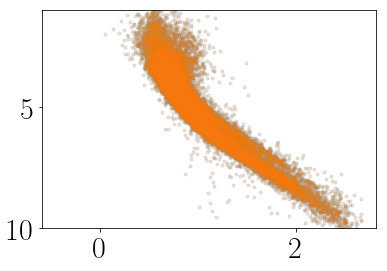

In [270]:
gaia_mc0 = pd.read_csv("../code/gaia_mc5.csv")
print(len(gaia_mc0))

travis = pd.read_csv("Ruth_McQuillan_Masses_Out.csv")
masses = pd.DataFrame(dict({"kepid": travis.KIC.values, "Mass": travis.iso_mass.values}))
masses.head()
gaia_mc0 = pd.merge(masses, gaia_mc0, how="right", on="kepid", suffixes=["_berger", ""])

# Cut out photometric binaries.
# m = gaia_mc0.flag.values == 1
# gaia_mc1 = gaia_mc0.iloc[m]*1
# print(np.shape(gaia_mc1), "no visual binaries or subgiants")
gaia_mc1 = gaia_mc0*1

plt.plot(gaia_mc0.bp_dered - gaia_mc0.rp_dered, gaia_mc0.abs_G, ".", alpha=.1)
plt.plot(gaia_mc1.bp_dered - gaia_mc1.rp_dered, gaia_mc1.abs_G, ".", alpha=.1)
plt.ylim(10, 1)

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
# m &= gaia_mc1.age.values > .5
# print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
mint, maxt = 3000, 6000
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

# Try cutting out stars with latitudes greater than bmax degrees
bmax = 15
m &= (gaia_mc1.b.values < bmax)
print(np.shape(gaia_mc1.iloc[m]), "no high latitude stars")

# # Restrict to stars with Vz
# m &= np.isfinite(gaia_mc1.vz.values)
# print(np.shape(gaia_mc1.iloc[m]), "only stars with Vz")

gaia_mc = gaia_mc1.iloc[m]

# Remove velocity outliers
v_clipped, clipping_mask = sigma_clip(gaia_mc.vb.values, 3)
gaia_mc = gaia_mc.iloc[clipping_mask]

For each point, calculate the velocity dispersion of the nearest 50 points.

In [180]:
np.random.seed(42)
x2, y2 = [np.random.randn(10000) + 10 for i in range(2)]
z2 = np.random.randn(10000)*y2

In [181]:
dispersions_nearest = calc_dispersion_nearest(x2, y2, z2, 1000);

100%|██████████| 10000/10000 [00:07<00:00, 1392.57it/s]


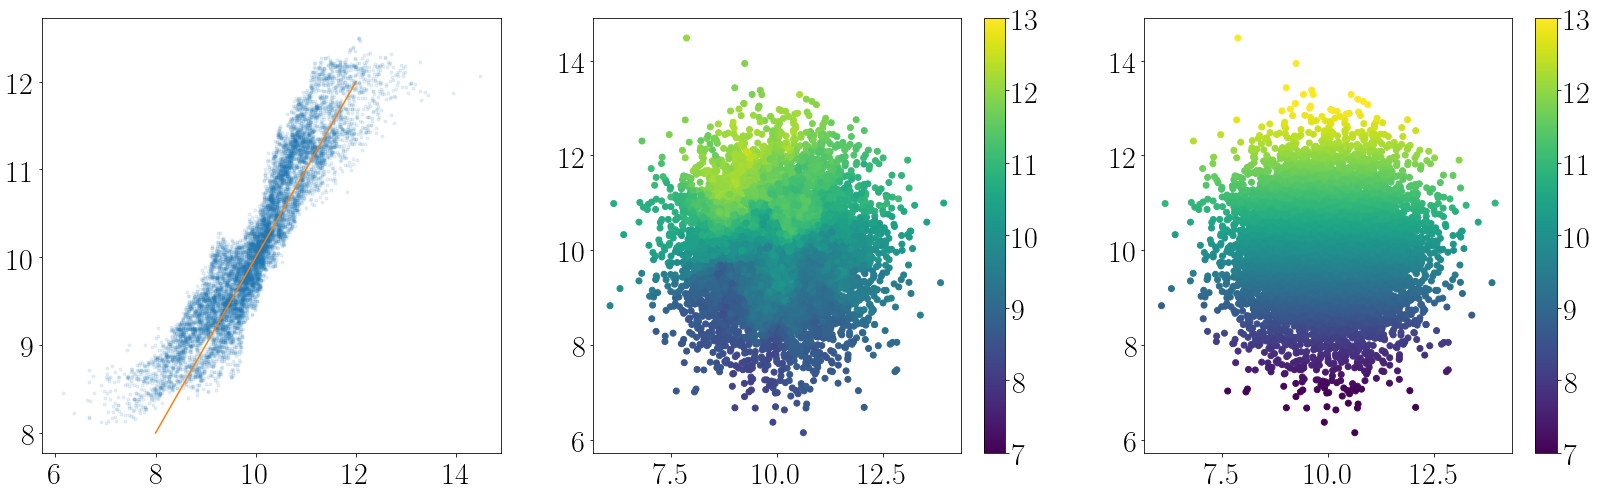

In [182]:
plt.figure(figsize=(28, 8))
    
plt.subplot(1, 3, 1)
plt.plot(y2, dispersions_nearest, ".", alpha=.1);
xs = np.linspace(8, 12, 100)
plt.plot(xs, xs)
    
plt.subplot(1, 3, 2)
plt.scatter(x2, y2, c=dispersions_nearest, vmax=13, vmin=7);
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(x2, y2, c=y2, vmax=13, vmin=7);
plt.colorbar()

In [183]:
dispersions_bins = calc_dispersion_bins(x2, y2, z2, 1.2, 1.2)

100%|██████████| 10000/10000 [00:02<00:00, 4878.67it/s]


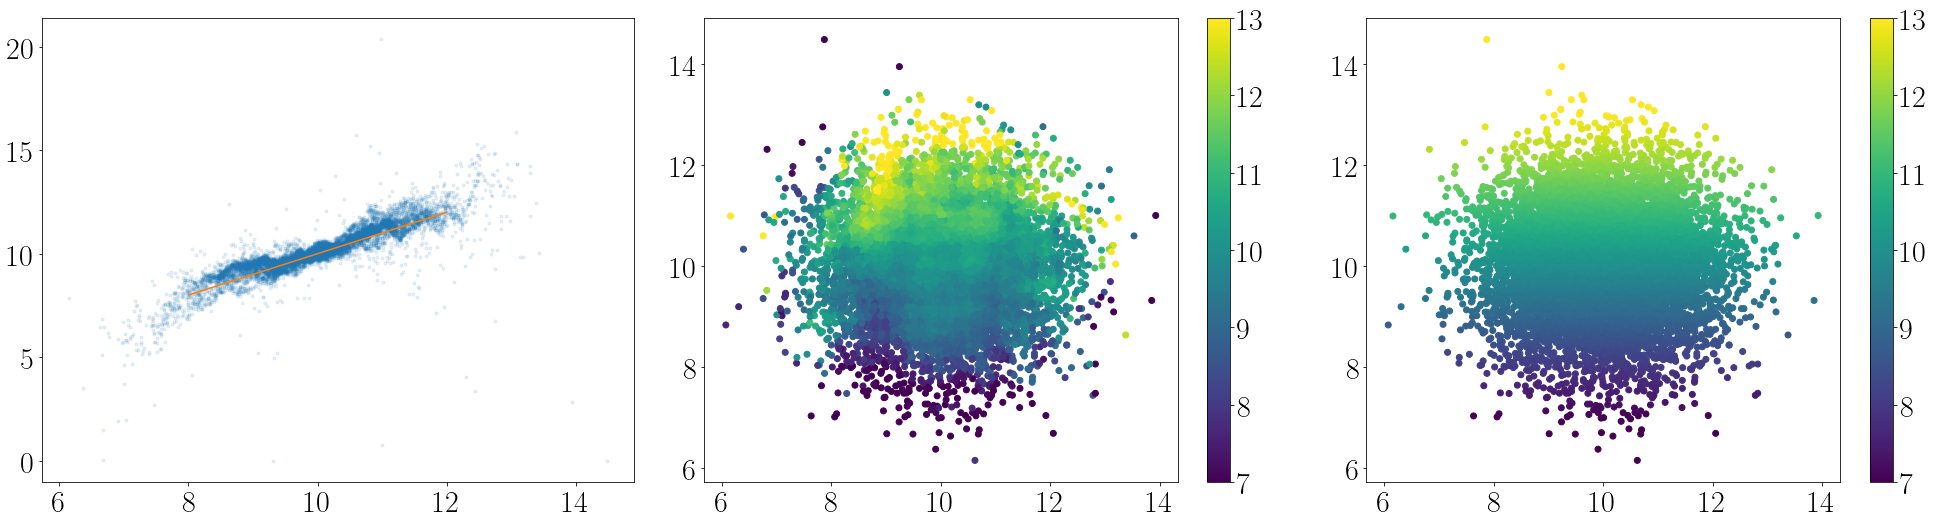

In [184]:
plt.figure(figsize=(28, 8))

plt.subplot(1, 3, 1)
plt.plot(y2, dispersions_bins, ".", alpha=.1);
plt.plot(xs, xs)
    
plt.subplot(1, 3, 2)
plt.scatter(x2, y2, c=dispersions_bins, vmax=13, vmin=7);
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(x2, y2, c=y2, vmax=13, vmin=7);
plt.colorbar()
    
plt.tight_layout()

In [271]:
def rescale(x):
    minx = min(x)
    _x = x - min(x)
    maxx = max(_x)
    return _x/max(_x), minx, maxx 

m = gaia_mc.flag.values == 1
x, minteff, maxteff = rescale(gaia_mc.color_teffs.values)
y, minp, maxp = rescale(np.log10(gaia_mc.Prot.values))
z = gaia_mc.vb.values

In [311]:
# dt, dp = .08, .12
dt, dp = .15, .25

dispersions_bins = calc_dispersion_bins(x, y, z, dt, dp)

100%|██████████| 15952/15952 [00:04<00:00, 3639.85it/s]


In [312]:
DT = dt * (max(gaia_mc.color_teffs.values) - min(gaia_mc.color_teffs.values))
DP = dp * (max(np.log10(gaia_mc.Prot.values)) - min(np.log10(gaia_mc.Prot.values)))
print(DT, DP)

396.7554289999567 0.6320477388769364


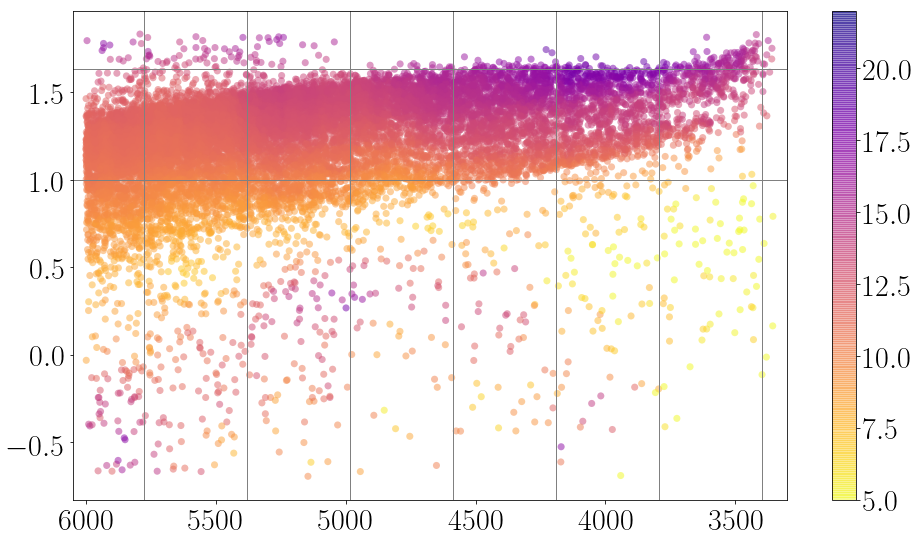

In [328]:
plt.figure(figsize=(16, 9))
teff_scaled, p_scaled = x*maxteff + minteff, y*maxp + minp

plt.scatter(teff_scaled, p_scaled, c=dispersions_bins, s=50, alpha=.5, edgecolor="", vmin=5, vmax=22, cmap="plasma_r", zorder=1)
# plt.yscale("log")
plt.colorbar()
plt.xlim(6050, 3300)

# plt.axhline(5)

xs = np.arange(3000, 6000, DT)
# ys = np.arange(.1, 100, 10**DP)
ys = np.arange(1, 2, DP)

for i in range(len(xs)):
    plt.axvline(xs[i], color=".5", lw=1, zorder=2)
for i in range(len(ys)):
    plt.axhline(ys[i], color=".5", lw=1, zorder=2)
# plt.fill_between(xs, 5, 5+ 10**DP, color="k", alpha=.2)

(6050, 3300)

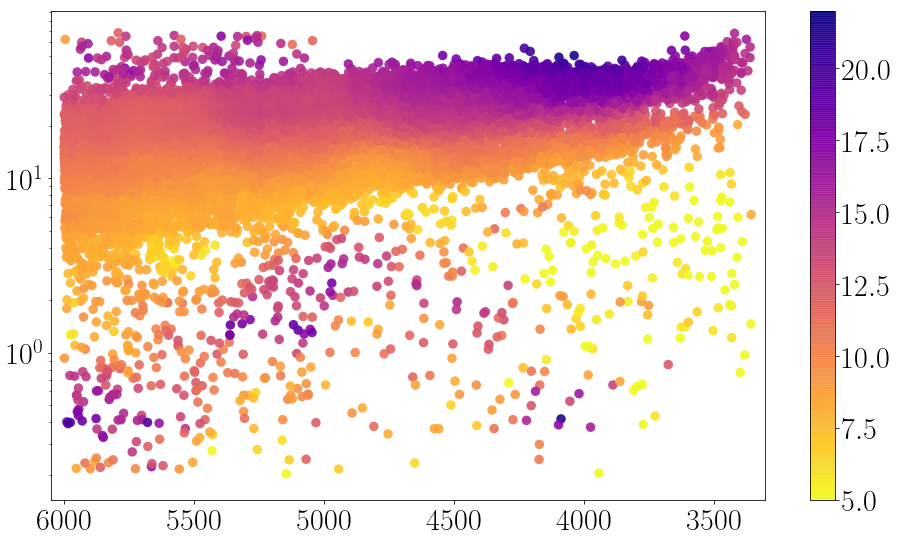

In [275]:
plt.figure(figsize=(16, 9))
teff_scaled, p_scaled = x*maxteff + minteff, y*maxp + minp

plt.scatter(teff_scaled, 10**p_scaled, c=dispersions_bins, s=90, alpha=.9, edgecolor="", vmin=5, vmax=22, cmap="plasma_r")
plt.yscale("log")
plt.colorbar()
plt.xlim(6050, 3300)

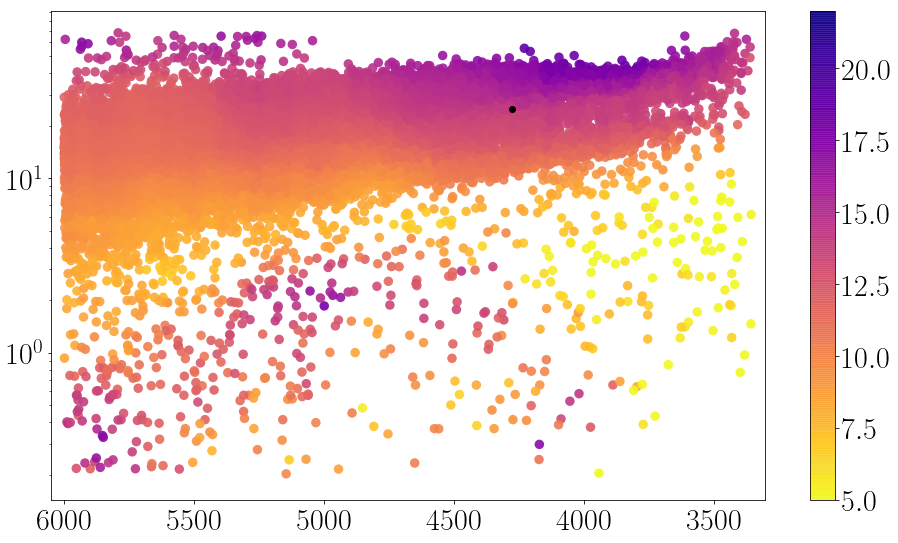

In [341]:
plt.figure(figsize=(16, 9))
teff_scaled, p_scaled = x*maxteff + minteff, y*maxp + minp

plt.scatter(teff_scaled, 10**p_scaled, c=dispersions_bins, s=90, alpha=.9, edgecolor="", vmin=5, vmax=22, cmap="plasma_r")
plt.yscale("log")
plt.colorbar()
plt.xlim(6050, 3300)
plt.plot(4275, 25, "ko")

Plot temperature slices.

Text(0, 0.5, 'Rotation period')

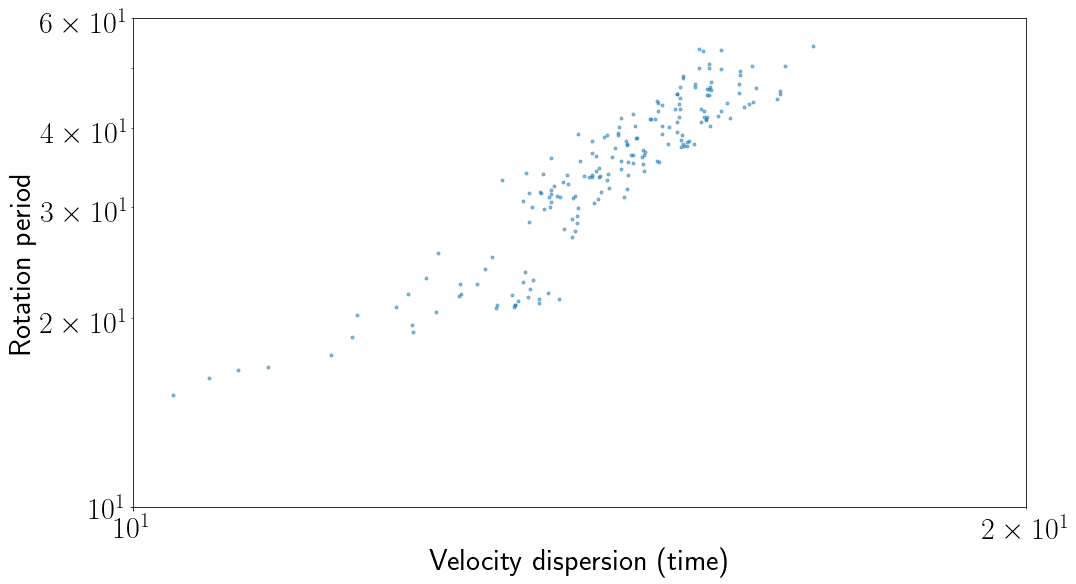

In [358]:
m = (4250 < teff_scaled) * (teff_scaled < 4300)

plt.figure(figsize=(16, 9))
# plt.plot(dispersions_bins[m], 10**p_scaled[m], ".", alpha=.5)
plt.xscale("log")
plt.yscale("log")
plt.xlim(5, 60)
# plt.axvline(25)

m = (4200 < teff_scaled) * (teff_scaled < 4250)
# plt.plot(dispersions_bins[m], 10**p_scaled[m], ".", alpha=.5)

m = (3500 < teff_scaled) * (teff_scaled < 3650)
# plt.plot(dispersions_bins[m], 10**p_scaled[m], ".", alpha=.5)
plt.plot(dispersions_bins[m], 10**p_scaled[m], ".", alpha=.5)


plt.xlim(10, 20)
plt.ylim(10, 60)

plt.xlabel("Velocity dispersion (time)")
plt.ylabel("Rotation period")

Text(0, 0.5, 'Rotation period')

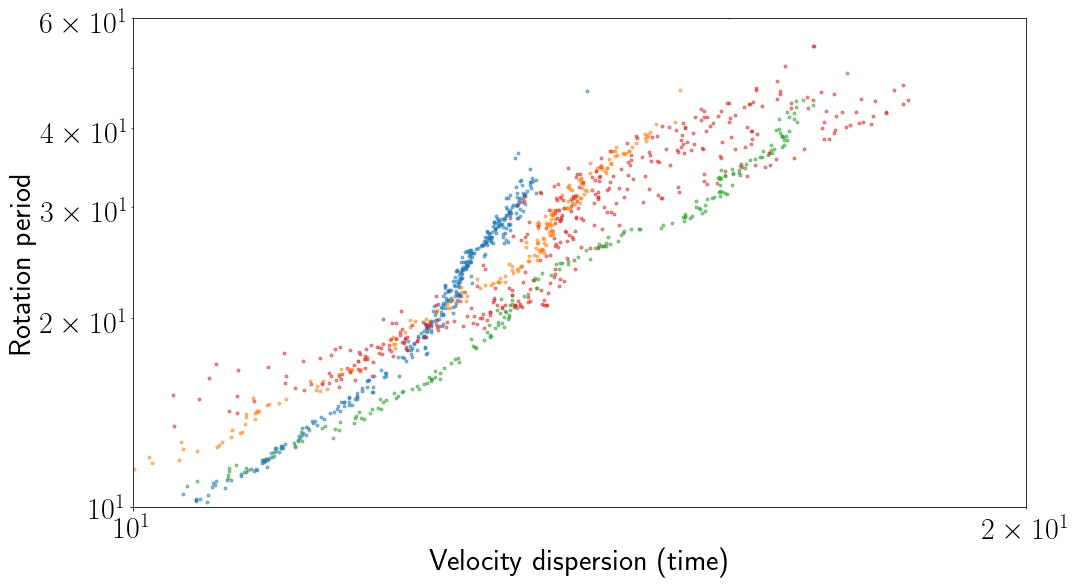

In [371]:

plt.figure(figsize=(16, 9))
plt.xscale("log")
plt.yscale("log")
plt.xlim(5, 60)
# plt.axvline(25)

m = (5250 < teff_scaled) * (teff_scaled < 5300)
plt.plot(dispersions_bins[m], 10**p_scaled[m], ".", alpha=.5)

m = (4750 < teff_scaled) * (teff_scaled < 4800)
plt.plot(dispersions_bins[m], 10**p_scaled[m], ".", alpha=.5)

m = (4250 < teff_scaled) * (teff_scaled < 4300)
plt.plot(dispersions_bins[m], 10**p_scaled[m], ".", alpha=.5)

m = (3600 < teff_scaled) * (teff_scaled < 3850)
plt.plot(dispersions_bins[m], 10**p_scaled[m], ".", alpha=.5)

plt.xlim(10, 20)
plt.ylim(10, 60)

# plt.axhline(25)

plt.xlabel("Velocity dispersion (time)")
plt.ylabel("Rotation period")

Text(0, 0.5, 'Rotation period')

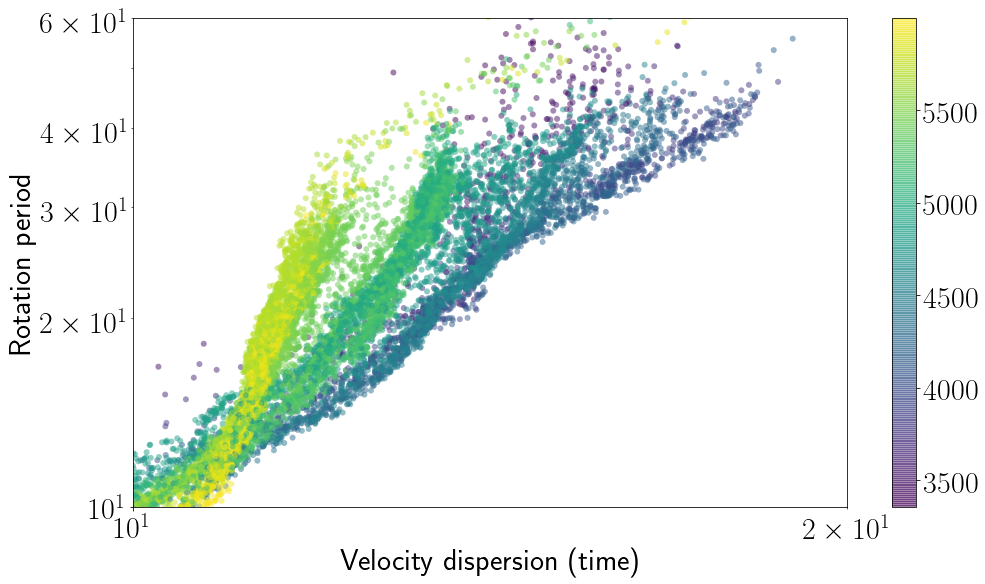

In [385]:
plt.figure(figsize=(16, 9))
plt.xscale("log")
plt.yscale("log")
plt.xlim(5, 60)
# plt.axvline(25)

# m = (5250 < teff_scaled) * (teff_scaled < 5300)
# plt.scatter(dispersions_bins[m], 10**p_scaled[m], c=np.log10(gaia_mc.Rper.values[m]), vmin=3.2, vmax=4.5)

# m = (4750 < teff_scaled) * (teff_scaled < 4800)
# plt.scatter(dispersions_bins[m], 10**p_scaled[m], c=np.log10(gaia_mc.Rper.values[m]), vmin=3.2, vmax=4.5)

# m = (4250 < teff_scaled) * (teff_scaled < 4300)
# plt.scatter(dispersions_bins[m], 10**p_scaled[m], c=np.log10(gaia_mc.Rper.values[m]), vmin=3.2, vmax=4.5)

# m = (3600 < teff_scaled) * (teff_scaled < 3850)
# plt.scatter(dispersions_bins[m], 10**p_scaled[m], c=np.log10(gaia_mc.Rper.values[m]), vmin=3.2, vmax=4.5)

# plt.scatter(dispersions_bins, 10**p_scaled, c=np.log10(gaia_mc.Rper.values), vmin=3.2, vmax=4.5, alpha=.5, edgecolor="")
plt.scatter(dispersions_bins, 10**p_scaled, c=gaia_mc.color_teffs.values, alpha=.5, edgecolor="")


plt.xlim(10, 20)
plt.ylim(10, 60)
plt.colorbar()

plt.xlabel("Velocity dispersion (time)")
plt.ylabel("Rotation period")

# Low variability when spin-down is increasing, high variability when spin down is decreasing.

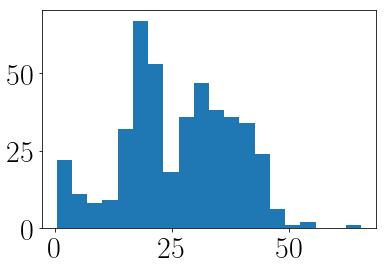

In [368]:
plt.hist(10**p_scaled[m], 20);

100%|██████████| 7262/7262 [00:01<00:00, 6636.89it/s]


(8, 70)

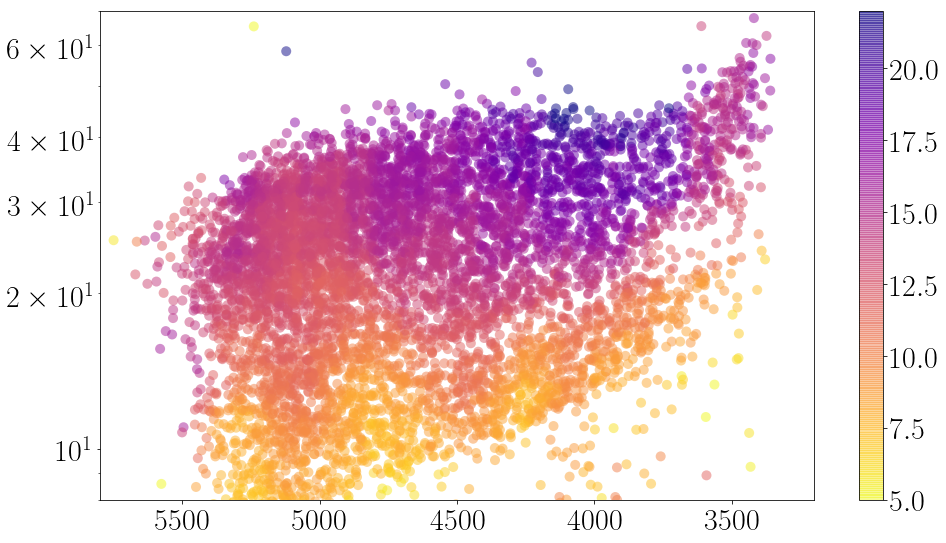

In [276]:
m = gaia_mc.flag.values == 1

dispersions_bins = calc_dispersion_bins(x[m], y[m], z[m], .08, .12)

plt.figure(figsize=(16, 9))
plt.scatter(teff_scaled[m], 10**p_scaled[m], c=dispersions_bins, s=100, alpha=.5, edgecolor="", vmin=5, vmax=22, cmap="plasma_r")
plt.yscale("log")
plt.colorbar()
plt.xlim(5800, 3200)
plt.ylim(8, 70)

In [277]:
dispersions_nearest = calc_dispersion_nearest(x, y, z, 30)

100%|██████████| 15952/15952 [00:18<00:00, 868.32it/s]


(6050, 3300)

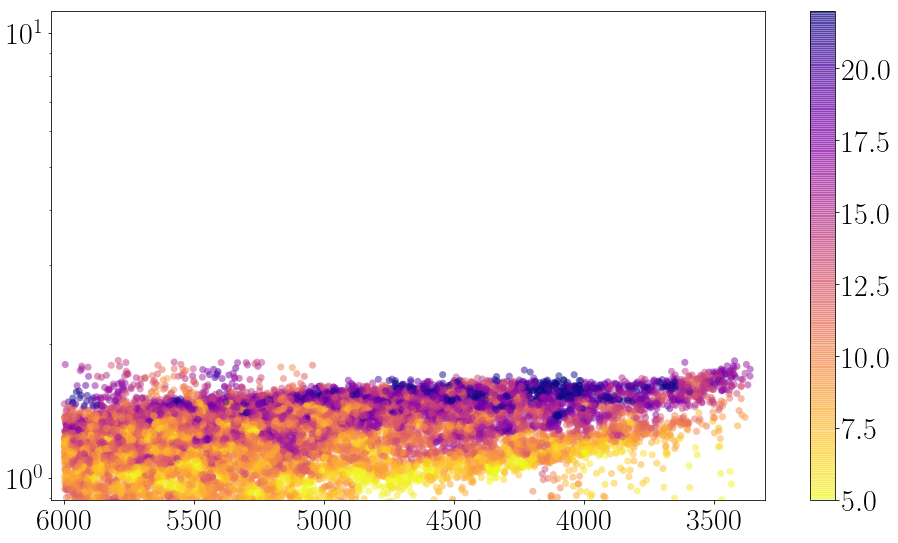

In [279]:
plt.figure(figsize=(16, 9))
# teff_scaled, p_scaled = x*maxteff + minteff, y*maxp + minp
plt.scatter(teff_scaled, p_scaled, c=dispersions_nearest, s=50, alpha=.5, edgecolor="", vmin=5, vmax=22, cmap="plasma_r")
plt.yscale("log")
plt.colorbar()
plt.xlim(6050, 3300)

(array([ 324.,  556.,  831., 1124., 1210., 1428., 1849., 2114., 2366.,
        2222.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

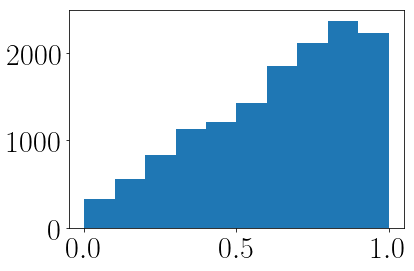